In [1]:
import datetime
import json
import os
import re


In [2]:
startTime = datetime.datetime.now()
print("Started: " + str(startTime))

stepTime = datetime.datetime.now()


Started: 2023-11-14 02:49:35.949382


In [3]:
def printStepTime(text):
    global stepTime
    endTime = datetime.datetime.now()
    print("Finished " + text + ": " + str(endTime) + ", took " + str(endTime - stepTime))
    stepTime = endTime


In [4]:
count = 0
desc = 0
media = 0
desc_media = 0
desc_lens = []


In [5]:
for file in os.listdir("data/chndm/"):
    if file == "index.txt":
        continue
    with open("data/chndm/" + file) as ndjson:
        for line in ndjson:
            #data = ujson.loads(line)
            data = json.loads(line)
            count += 1
            hasDesc = False
            hasMedia = False
            if 'content' in data:
                if 'descriptiveNonRepeating' in data['content']:
                    if 'online_media' in data['content']['descriptiveNonRepeating']:
                        if 'media' in data['content']['descriptiveNonRepeating']['online_media']:
                            if len(data['content']['descriptiveNonRepeating']['online_media']['media']) > 0:
                                hasMedia = True
                                media += 1
                if 'freetext' in data['content']:
                    if 'notes' in data['content']['freetext']:
                        for text in data['content']['freetext']['notes']:
                            if text['label'] == "Description":
                                desc_lens.append(len(text['content']))
                                hasDesc = True
                        if hasDesc == True:
                            desc += 1
            if hasDesc == True and hasMedia == True:
                desc_media += 1


In [6]:
print("Desc: ",desc, "/", count)
print("Media:",media, "/", count)
print("Both: ",desc_media, "/", count)


Desc:  40770 / 43809
Media: 43258 / 43809
Both:  40241 / 43809


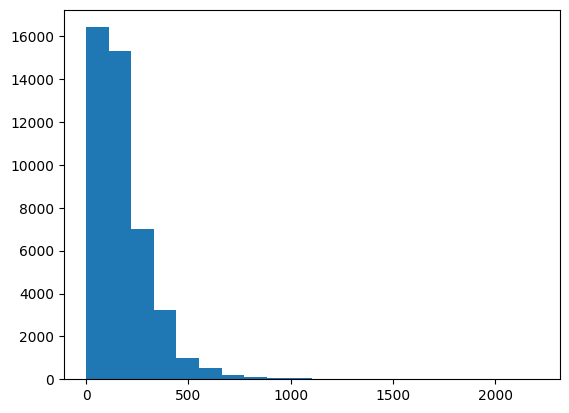

In [7]:
import matplotlib.pyplot as plt
plt.hist(desc_lens, bins=20)
plt.show()


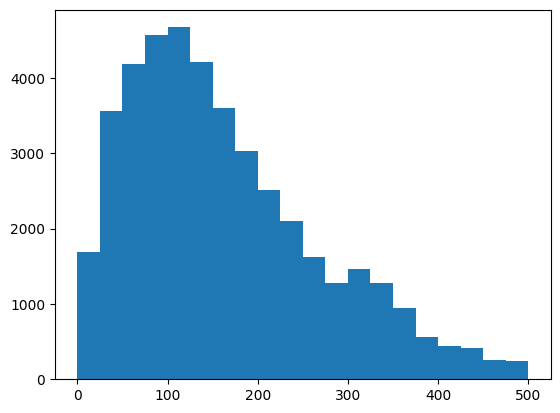

In [8]:
import matplotlib.pyplot as plt
plt.hist(desc_lens, bins=20, range=(0,500))
plt.show()


In [9]:
files = []

with open('si-media.txt') as file:
  for line in file:
    files.append(line.strip())


## Picking records
This will add a record to the list if it meets the following conditions:
* Part of the Cooper Hewitt unit
* Has a Description that is 120-400 characters long and does not contain " / "
* Has a JPEG media file that's licensed under CC0, both dimensions are >1000px, and we know exists

Rationale:
* We know Cooper Hewitt has made a concerted effort to improve Descriptions
* Descriptions containing " / " typically contain other tombstone data (such as credit lines), which do not describe the image and are not desired
* We want Descriptions that are about 2-4x as long as NoCaps
  * Descriptions in the NoCaps dataset are typically 45-70 characters long (or 30-100 if you want to use a slightly looser range)
  * Using 120-400 as a range gets to about 2-4x that and from a quick viewing of the data looks to get reasonable Descriptions
* Only using JPEG files since they're significantly smaller than TIFFs
* Only use CC0 media to avoid copyright issues
* Only use images with large enough dimensions to be of note
  * Using 1000px in each dimension as a simple filter
* Only use images we know the files exist for
  * There are a few IDs that didn't match files, but some of them have other media which we can match
  * (This could be due to the file name having other stuff in it or using .jpeg instead of .jpg, for example)
* All of these constraints help reduce the total dataset size
  * Cooper Hewitt has ~770GB of JPG images in the bucket; we don't want to have to download all of that

In [10]:
ids_media = {}

for file in os.listdir("data/chndm/"):
    if file == "index.txt":
        continue
    with open("data/chndm/" + file) as ndjson:
        for line in ndjson:
            #data = ujson.loads(line)
            data = json.loads(line)
            desc = ""
            media_ids = []
            if 'content' in data:
                if 'freetext' in data['content']:
                    if 'notes' in data['content']['freetext']:
                        for text in data['content']['freetext']['notes']:
                            if text['label'] == "Description":
                                if len(text['content']) > 120 and len(text['content']) < 400 and " / " not in text['content']:
                                    desc = text['content']
                if 'descriptiveNonRepeating' in data['content']:
                    if 'online_media' in data['content']['descriptiveNonRepeating']:
                        if 'media' in data['content']['descriptiveNonRepeating']['online_media']:
                            if len(data['content']['descriptiveNonRepeating']['online_media']['media']) > 0:
                                for media in data['content']['descriptiveNonRepeating']['online_media']['media']:
                                    if media['type'] == "Images":
                                        if media['usage']['access'] == "CC0":
                                            if 'resources' in media:
                                                for resource in media["resources"]:
                                                    if resource['label'] == "High-resolution JPEG":
                                                        if resource['width'] > 1000 and resource['height'] > 1000:
                                                            if f"{media['idsId']}.jpg" in files:
                                                                media_ids.append(media['idsId'])
            if desc != "" and len(media_ids) > 0:
                ids_media[data["id"]] = { "desc": desc, "media": media_ids[0]}


In [11]:
print(len(ids_media))


20138


In [12]:
from sklearn.model_selection import train_test_split

# Create a train/test split, with testing having 5k records
ids_train, ids_test = train_test_split([[k,v['media'],v['desc']] for k,v in ids_media.items()], test_size=0.1)


In [13]:
import pandas as pd

pd.DataFrame(ids_train, columns=['id','media_id','description']).to_csv("ids_train.csv")
pd.DataFrame(ids_test, columns=['id','media_id','description']).to_csv("ids_test.csv")
